In [277]:
import pandas as pd
import numpy
pd.set_option('display.max_rows' , None)
pd.set_option('display.max_columns' , None)
import sys
numpy.set_printoptions(threshold=sys.maxsize)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import xgboost
from xgboost import XGBClassifier

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score


In [3]:
item_data = pd.read_csv(r'C:\Users\ezchave\Desktop\DS\WNS Hackathon\item_data.csv')
sample_submission = pd.read_csv(r'C:\Users\ezchave\Desktop\DS\WNS Hackathon\sample_submission.csv')
test = pd.read_csv(r'C:\Users\ezchave\Desktop\DS\WNS Hackathon\test.csv')
train = pd.read_csv(r'C:\Users\ezchave\Desktop\DS\WNS Hackathon\train.csv')
view_log = pd.read_csv(r'C:\Users\ezchave\Desktop\DS\WNS Hackathon\view_log.csv')


In [166]:
train = pd.read_csv(r'C:\Users\ezchave\Desktop\DS\WNS Hackathon\train.csv')

In [5]:
sample_submission.shape

(90675, 2)

In [6]:
test.shape

(90675, 6)

In [7]:
train.shape

(237609, 7)

In [8]:
view_log.shape

(3118622, 5)

In [9]:
item_data.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [10]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [11]:
sample_submission.head()

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0
1,caac14a5bf2ba283db7708bb34855760,0
2,13f10ba306a19ce7bec2f3cae507b698,0
3,39c4b4dc0e9701b55a0a4f072008fb3f,0
4,bf5a572cca75f5fc67f4b14e58b11d70,0


In [12]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


In [13]:
train.user_id.unique().shape

(74723,)

In [14]:
test_dates = (pd.to_datetime(test.impression_time.unique()).strftime('%d%m%Y'))
sorted(set(test_dates))

['12122018',
 '13122018',
 '14122018',
 '15122018',
 '16122018',
 '17122018',
 '18122018']

In [15]:
train_dates = pd.to_datetime(train.impression_time.unique()).strftime('%d%m%Y')
sorted(set(train_dates))

['01122018',
 '02122018',
 '03122018',
 '04122018',
 '05122018',
 '06122018',
 '07122018',
 '08122018',
 '09122018',
 '10122018',
 '11122018',
 '12122018',
 '13122018',
 '15112018',
 '16112018',
 '17112018',
 '18112018',
 '19112018',
 '20112018',
 '21112018',
 '22112018',
 '23112018',
 '24112018',
 '25112018',
 '26112018',
 '27112018',
 '28112018',
 '29112018',
 '30112018']

In [16]:
train[train.user_id == 87861].head(20)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
130795,5f2d2b148d5754dd46529c929a8368ee,2018-12-02 01:20:00,87861,213,intermediate,0,0
158428,4c8f7e370141222c5a6ac683c048f28d,2018-12-01 21:38:00,87861,213,intermediate,0,0
164684,48c9538fe2527d4cd71b8dca4e7992a2,2018-12-01 21:34:00,87861,213,intermediate,0,0
165860,b0ab277f4394c09486f226822b1ef4f4,2018-12-02 01:18:00,87861,213,intermediate,0,0


In [16]:
# make changes to view_log for better analysis
# get the count of user log in view_log table
view_log = pd.merge(view_log,pd.DataFrame(view_log['user_id'].value_counts()).reset_index().rename(columns = {'user_id':'count','index':'user_id'}),how = 'inner',on ='user_id')
view_log.server_time = pd.to_datetime(view_log.server_time)
# make device type and integer number for better analytics
view_log['device_type_'] = view_log['device_type'].map(lambda x : 1 if x == 'android' else (2 if x == 'iphone' else 3))
view_log.device_type_ = view_log.device_type_.astype(int)
#remove character device  type
view_log.drop('device_type',axis = 1, inplace =True)
view_log.rename(columns = {'device_type_' : 'device_type'},inplace =True)
# combine view_log and item data to get a comprehensive view of the data we have on each customer
view_log = pd.merge(view_log, item_data, how = 'inner',on = 'item_id')

In [17]:
train[train.user_id == 4557].head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
63675,6dd9544216149618da55e183f73e2b56,2018-11-26 14:37:00,4557,213,latest,1,0
66024,6ba86f2d1de0989ffbf73cc37f5825c9,2018-11-26 14:35:00,4557,213,latest,1,0


In [18]:
# let's see the correlation among the variables of this view_log
view_log.corr()
# here we see that none of these columns are correlated so nothing needs to be removed

,session_id,user_id,item_id,count,device_type,item_price,category_1,category_2,category_3,product_type
session_id,1.000000,0.001938,-0.001490,0.004423,-0.000049,0.000714,-0.000742,-0.000450,0.000779,0.000241
user_id,0.001938,1.000000,0.000062,0.016048,-0.002112,-0.001855,0.000126,0.001561,0.000471,-0.000128
item_id,-0.001490,0.000062,1.000000,0.001911,-0.000865,0.001008,0.009194,-0.041625,0.020189,-0.002414
count,0.004423,0.016048,0.001911,1.000000,-0.005301,0.005005,0.004032,0.001602,0.003963,0.006237
device_type,-0.000049,-0.002112,-0.000865,-0.005301,1.000000,-0.001991,0.000690,-0.000781,-0.000781,-0.001781
item_price,0.000714,-0.001855,0.001008,0.005005,-0.001991,1.000000,-0.213013,-0.127761,0.015197,0.023355
category_1,-0.000742,0.000126,0.009194,0.004032,0.000690,-0.213013,1.000000,0.042994,0.038970,-0.033455
category_2,-0.000450,0.001561,-0.041625,0.001602,-0.000781,-0.127761,0.042994,1.000000,0.065840,-0.026686
category_3,0.000779,0.000471,0.020189,0.003963,-0.000781,0.015197,0.038970,0.065840,1.000000,-0.021320
product_type,0.000241,-0.000128,-0.002414,0.006237,-0.001781,0.023355,-0.033455,-0.026686,-0.021320,1.000000


In [19]:
view_log.head()

,server_time,session_id,user_id,item_id,count,device_type,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,112333,4557,32970,39,1,54685,16,56,253,3184
1,2018-11-19 11:28:00,529521,52460,32970,315,1,54685,16,56,253,3184
2,2018-11-04 18:53:00,935926,2014,32970,654,1,54685,16,56,253,3184
3,2018-12-10 01:52:00,39867,2014,32970,654,1,54685,16,56,253,3184
4,2018-11-16 16:40:00,248405,23824,32970,189,1,54685,16,56,253,3184


In [20]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [167]:
train.impression_time = pd.to_datetime(train.impression_time)
train['impression_hour'] = train.impression_time.dt.strftime('%H')
train.impression_hour = train.impression_hour.astype(int)

In [22]:
click_1_hrs = train[train.is_click == 1].impression_hour

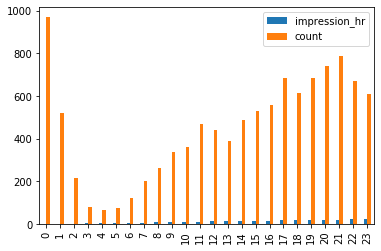

In [23]:
# let's see the distribution of clicks around the hours of the day
pd.DataFrame(click_1_hrs.value_counts()).reset_index().rename(columns = {'index':'impression_hr','impression_hour':'count'}).sort_values('impression_hr').reset_index(drop= True).plot.bar()

In [71]:
view_log['server_hour'] = view_log.server_time.dt.strftime('%H')
view_log['server_day'] = view_log.server_time.dt.strftime('%A')


In [72]:
view_log[view_log.user_id == 52460]

,server_time,session_id,user_id,item_id,count,device_type,item_price,category_1,category_2,category_3,product_type,server_hour,server_day
1,2018-11-19 11:28:00,529521,52460,32970,315,1,54685,16,56,253,3184,11,Monday
11346,2018-11-10 11:35:00,244887,52460,119516,315,1,1856,17,8,113,10025,11,Saturday
81576,2018-10-20 11:08:00,732280,52460,129764,315,1,9523,17,8,159,5276,11,Saturday
88955,2018-10-15 09:00:00,1079134,52460,89734,315,1,1594,16,15,53,7525,09,Monday
109284,2018-10-23 19:52:00,101556,52460,99955,315,1,4016,14,62,315,186,19,Tuesday
143860,2018-11-02 08:11:00,845286,52460,82763,315,1,3840,13,58,75,8013,08,Friday
143861,2018-11-04 09:47:00,894976,52460,82763,315,1,3840,13,58,75,8013,09,Sunday
143862,2018-11-04 09:48:00,894976,52460,82763,315,1,3840,13,58,75,8013,09,Sunday
156333,2018-11-04 09:44:00,894976,52460,58320,315,1,1075,13,58,173,5358,09,Sunday
163117,2018-10-16 10:25:00,105294,52460,7496,315,1,4595,0,45,81,382,10,Tuesday


In [79]:
view_log['last_item_datetime','item_most_seen','last_item_price'] = 'n'

In [147]:
view_log['max_viewed_item'] = view_log.groupby('user_id').item_id.transform(lambda x : (x).value_counts().max())
view_log['last_view_date'] = view_log.groupby('user_id').server_time.transform(max)

In [149]:
view_log['last_item_price'] = view_log.groupby('user_id').item_price.transform(max)

In [152]:
view_log['server_day_most_frequent'] = view_log.groupby('user_id').server_day.transform(lambda x : x.value_counts().max())

In [153]:
view_log['server_hr_most_frequent'] = view_log.groupby('user_id').server_hour.transform(lambda x : x.value_counts().max())

In [163]:
view_log['device_type_max'] = view_log.groupby('user_id').device_type.transform(lambda x : x.value_counts().idxmax())

In [164]:
view_log[view_log.user_id == 4557].head()


,server_time,session_id,user_id,item_id,count,device_type,item_price,category_1,category_2,category_3,product_type,server_hour,server_day,item_most_seen,last_item_price,last_item_datetime,max_viewed_item,last_view_date,server_day_most_frequent,server_hr_most_frequent,device_type_max
0,2018-10-15 08:58:00,112333,4557,32970,39,1,54685,16,56,253,3184,08,Monday,7,5690,2018-11-26 23:40:00,7,2018-11-26 23:40:00,10,6,1
1301,2018-10-15 08:59:00,112333,4557,132775,39,1,480,4,1,111,9362,08,Monday,7,5690,2018-11-26 23:40:00,7,2018-11-26 23:40:00,10,6,1
1389,2018-10-15 08:59:00,112333,4557,100092,39,1,377,0,6,145,10036,08,Monday,7,5690,2018-11-26 23:40:00,7,2018-11-26 23:40:00,10,6,1
1840,2018-10-15 09:01:00,112333,4557,115470,39,1,8019,13,78,134,2874,09,Monday,7,5690,2018-11-26 23:40:00,7,2018-11-26 23:40:00,10,6,1
1887,2018-10-15 09:03:00,112333,4557,35370,39,1,480,0,6,50,1457,09,Monday,7,5690,2018-11-26 23:40:00,7,2018-11-26 23:40:00,10,6,1


In [169]:
#calculation click through Rate
#CTR= no of clicks of 1 /total no of impressions
df_click=train[train.is_click==1]
df_click=df_click[['impression_hour','is_click']].groupby(['impression_hour']).count().reset_index()

df_hour=train[['impression_hour','is_click']].groupby(['impression_hour']).count().reset_index()
df_hour = df_hour.rename(columns={'is_click': 'impressions'})
df_hour.head()

df_click['clicks']=df_hour['impressions']
df_click.head()

df_click['CTR']=df_click['is_click']/df_click['clicks']*100
df_click.head(24)
train=pd.merge(train,df_click[['CTR','impression_hour']],on ='impression_hour',how='left')
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impression_hour,CTR_x,CTR_y
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,4.573099,4.573099
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,4.573099,4.573099
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,4.573099,4.573099
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0,4.573099,4.573099
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,0,4.573099,4.573099


In [68]:
train["impression_day"]=train.impression_time.dt.strftime("%A")
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impression_hour,CTR,impression_day
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,4.573099,Thursday
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,4.573099,Thursday
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,4.573099,Thursday
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0,4.573099,Thursday
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,0,4.573099,Thursday


In [155]:
train.shape

(237609, 10)

In [170]:
train =pd.merge(train,view_log[['user_id','last_view_date','device_type_max','count']].drop_duplicates(),on = 'user_id',how = 'left' )

In [158]:
#train.drop({'user_id','last_view_date','device_type_max','count'},axis=1,inplace=True)

In [159]:
#train.drop_duplicates(inplace=True)

In [171]:
train.shape

(237609, 13)

In [175]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237609 entries, 0 to 237608
Data columns (total 12 columns):
impression_id      237609 non-null object
impression_time    237609 non-null datetime64[ns]
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
impression_hour    237609 non-null int32
CTR_y              237609 non-null float64
last_view_date     237606 non-null datetime64[ns]
device_type_max    237606 non-null float64
count              237606 non-null float64
dtypes: datetime64[ns](2), float64(3), int32(1), int64(4), object(2)
memory usage: 22.7+ MB


In [176]:
train['recency'] = train['impression_time'] - train['last_view_date']

In [185]:
view_log.device_type_max.value_counts()

1    3115910
2        930
Name: device_type_max, dtype: int64

In [178]:
train.shape

(237609, 13)

In [184]:
# find a way to give each user a score 
train.device_type_max.value_counts()

1.0    237537
2.0        69
Name: device_type_max, dtype: int64

In [254]:
X =train.copy()
X.drop({'last_view_date','impression_id','impression_time'},axis = 1, inplace = True)
X.drop_duplicates(inplace=True)
#X.fillna(0)
# make os_version a int 
X['os_version_'] = X['os_version'].map(lambda x : 1 if x == 'latest' else (2 if x == 'intermediate' else 3))
X.os_version_ = X.os_version_.astype(int)
#remove character os_version
X.drop('os_version',axis = 1, inplace =True)
X.rename(columns = {'os_version_' : 'os_version'},inplace =True)
# one hot encode the columns device type and os version for better analysis via binary values in columns
dummies_device_type  = pd.get_dummies(X['device_type_max'])
dummies_device_type.rename(columns = {1 : 'device_type_1',2 : 'device_type_2', 3 : 'device_type_3' },inplace = True)
dummies_os_version = pd.get_dummies(X['os_version'])
dummies_os_version.rename(columns = {1 : 'os_version_1',2 : 'os_version_2', 3 : 'os_version_3' },inplace = True)
X = X.join(dummies_os_version)
X = X.join(dummies_device_type)
X.drop({'device_type_max','os_version'},inplace=True,axis=1)
X.shape
# make the features and labels dataframes
y = X[['is_click']]
X.drop('is_click',inplace=True,axis = 1)
X.reset_index(inplace=True, drop=True)

In [183]:
X.head()

,user_id,app_code,is_4G,impression_hour,CTR_y,count,recency,os_version_1,os_version_2,os_version_3,device_type_1,device_type_2
0,87862,422,0,0,4.573099,1.0,26 days 05:49:00,0,0,1,1,0
1,63410,467,1,0,4.573099,12.0,-26 days +03:58:00,1,0,0,1,0
2,71748,259,1,0,4.573099,2.0,-9 days +12:02:00,0,1,0,1,0
3,69209,244,1,0,4.573099,18.0,-9 days +07:23:00,1,0,0,1,0
4,62873,473,0,0,4.573099,46.0,-27 days +01:06:00,1,0,0,1,0


In [258]:
X.loc[:,'recency'] =  X.loc[:,'recency'].dt.seconds

In [230]:
X.recency = X.recency.fillna(0)

In [231]:
X.recency = X.recency.astype(int)

In [247]:
X.drop('os_version_1',axis=1,inplace=True) # recency,ctr,impression_hour,count,os_version_1

In [259]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237409 entries, 0 to 237408
Data columns (total 12 columns):
user_id            237409 non-null int32
app_code           237409 non-null int32
is_4G              237409 non-null int32
impression_hour    237409 non-null int32
CTR_y              237409 non-null int32
count              237409 non-null int32
recency            237409 non-null int64
os_version_1       237409 non-null uint8
os_version_2       237409 non-null uint8
os_version_3       237409 non-null uint8
device_type_1      237409 non-null uint8
device_type_2      237409 non-null uint8
dtypes: int32(6), int64(1), uint8(5)
memory usage: 8.4 MB


In [260]:
X = X.fillna(0)
for cols in X.columns :
    X[cols] = X[cols].astype(int)
X.head()


,user_id,app_code,is_4G,impression_hour,CTR_y,count,recency,os_version_1,os_version_2,os_version_3,device_type_1,device_type_2
0,87862,422,0,0,4,1,20940,0,0,1,1,0
1,63410,467,1,0,4,12,14280,1,0,0,1,0
2,71748,259,1,0,4,2,43320,0,1,0,1,0
3,69209,244,1,0,4,18,26580,1,0,0,1,0
4,62873,473,0,0,4,46,3960,1,0,0,1,0


In [261]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y)

In [262]:
rfc = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
rfc.fit(X_train.values,Y_train.values)


C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [263]:
yhat = rfc.predict(X_test.fillna(0).values)
yhat_prob = rfc.predict_proba(X_test.fillna(0).values)[:,1]


In [264]:
print(confusion_matrix(yhat,Y_test.values))
print(classification_report(yhat,Y_test.values))

[[55835  2526]
 [  697   295]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     58361
           1       0.10      0.30      0.15       992

    accuracy                           0.95     59353
   macro avg       0.55      0.63      0.56     59353
weighted avg       0.97      0.95      0.96     59353



### Applying SMOTE now to over sample tp

In [267]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['upsell'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of upsell in oversampled data",len(os_data_y[os_data_y['upsell']==1]))
print("Number of non upsell customers",len(os_data_y[os_data_y['upsell']==0]))
print("Proportion of  upsell data in oversampled data is ",len(os_data_y[os_data_y['upsell']==1])/len(os_data_X))
print("Proportion of no upsell data in oversampled data is ",len(os_data_y[os_data_y['upsell']==0])/len(os_data_X))


C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  317144
Number of upsell in oversampled data 158572
Number of non upsell customers 158572
Proportion of  upsell data in oversampled data is  0.5
Proportion of no upsell data in oversampled data is  0.5


In [269]:
rfc = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
rfc.fit(os_data_X.values,os_data_y.values)


C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [270]:
yhat = rfc.predict(X_test.fillna(0).values)
yhat_prob = rfc.predict_proba(X_test.fillna(0).values)[:,1]


In [272]:
print(confusion_matrix(yhat,y_test.values))
print(classification_report(yhat,y_test.values))

[[65814  2708]
 [ 2164   537]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     68522
           1       0.17      0.20      0.18      2701

    accuracy                           0.93     71223
   macro avg       0.57      0.58      0.57     71223
weighted avg       0.94      0.93      0.93     71223



In [282]:
os_data_X.head()

,user_id,app_code,is_4G,impression_hour,CTR_y,count,recency,os_version_1,os_version_2,os_version_3,device_type_1,device_type_2,is_click
0,30358,463,0,21,5,18,3540,1,0,0,1,0,0
1,64986,249,1,16,4,32,22980,1,0,0,1,0,0
2,10057,207,1,14,4,6,53340,1,0,0,1,0,0
3,12283,296,0,9,4,3,37860,0,1,0,1,0,0
4,41619,469,0,15,4,7,75540,1,0,0,1,0,0


In [304]:
# Create train and test set 
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)
print("Taille des predictor sur le train set : ", train_X.shape)
print("Taille de la target sur le train set : ", train_y.shape)
print("Taille des predictor sur le test set : ", test_X.shape)
print("Taille de la target sur le test set : ", test_y.shape)
from sklearn.preprocessing import Imputer
my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

Taille des predictor sur le train set :  (178056, 12)
Taille de la target sur le train set :  (178056, 1)
Taille des predictor sur le test set :  (59353, 12)
Taille de la target sur le test set :  (59353, 1)


C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [287]:
from xgboost import XGBRegressor
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

"""
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
"""

# Performance sur le train
train_y_pred = my_model.predict(train_X)
auc = roc_auc_score(train_y, train_y_pred)
print("Performance sur le train : ", auc)

# Performance sur le test
test_y_pred = my_model.predict(test_X)
auc = roc_auc_score(test_y, test_y_pred)
print("Performance sur le test : ", auc)


[18:20:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Performance sur le train :  0.7539912224763674
Performance sur le test :  0.745827116719348


In [315]:
test_y.shape

(59353, 1)

### Let's try with oversampled data

In [300]:
train_X,train_y=os.fit_sample(train_X, train_y)


C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [301]:
from xgboost import XGBRegressor
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

"""
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
"""

# Performance sur le train
train_y_pred = my_model.predict(train_X)
auc = roc_auc_score(train_y, train_y_pred)
print("Performance sur le train : ", auc)

# Performance sur le test
test_y_pred = my_model.predict(test_X)
auc = roc_auc_score(test_y, test_y_pred)
print("Performance sur le test : ", auc)


[12:47:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Performance sur le train :  0.9759864648985027
Performance sur le test :  0.6930385663709517


There are in general two ways that you can control overfitting in xgboost :

The first way is to directly control model complexity◦This include max_depth, min_child_weight and gamma

The second way is to add randomness to make training robust to noise◦This include subsample, colsample_bytree
You can also reduce stepsize eta, but needs to remember to increase num_round when you do so

In [428]:
# taking non over sampled data again
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=2, 
             eval_set=[(test_X, test_y)], verbose=False)
# Performance sur le train
train_y_pred = my_model.predict(train_X)
auc = roc_auc_score(train_y, train_y_pred)
print("Performance sur le train : ", auc)

# Performance sur le test
test_y_pred = my_model.predict(test_X)
auc = roc_auc_score(test_y, test_y_pred)
print("Performance sur le test : ", auc)



[18:55:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Performance sur le train :  0.7505499452984844
Performance sur le test :  0.7457682339014293


In [430]:
########### Fix learning rate and number of estimators for tuning tree-based parameters
# max deplt 5 -> 56% / 54% accuracy
#max depth 7 -> 62% / 54%  accrucacy
xgb = XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,scale_pos_weight=1,seed=27)
# modelfit(xgb1, train, train_X)
xgb.fit(train_X, train_y)

# Performance sur le train
auc = roc_auc_score(train_y, xgb1.predict(train_X))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(test_y, xgb1.predict(test_X))
print("Performance sur le test : ", auc)


C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Performance sur le train :  0.5422433680429978
Performance sur le test :  0.5396427202306361


AUC: 0.75


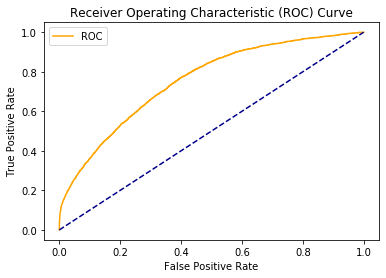

In [431]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
probs = xgb.predict_proba(test_X)
auc = roc_auc_score(test_y, probs[:,1])
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs[:,1])
plot_roc_curve(fpr, tpr)

In [432]:
print(classification_report(test_y,xgb.predict(test_X)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56575
           1       0.64      0.08      0.14      2778

    accuracy                           0.95     59353
   macro avg       0.80      0.54      0.56     59353
weighted avg       0.94      0.95      0.94     59353



In [316]:
##########Tune max_depth and min_child_weight
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=5,
                                                  min_child_weight=1,
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch1.fit(train_X,train_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [324]:
gsearch1.cv_results_

{'mean_fit_time': array([156.44997144, 151.95487895, 151.26280208, 241.01830702,
        221.00055041, 209.96373305, 311.77366409, 295.28283663,
        264.44483824, 682.72389088, 468.6167501 , 228.92903328]),
 'std_fit_time': array([  1.03391085,   4.61660892,   4.7728358 ,   3.93258994,
          7.06528588,   5.56813399,  10.49772196,  16.01680603,
          1.70543067, 244.17677727, 215.62128265,  30.09584573]),
 'mean_score_time': array([0.77186642, 0.71815324, 0.67578464, 1.31520014, 1.18614912,
        1.1659277 , 1.99853392, 1.82066512, 1.70290704, 3.32202315,
        2.31716595, 1.64517879]),
 'std_score_time': array([0.07379144, 0.08694642, 0.03434405, 0.04003199, 0.05197364,
        0.0224957 , 0.0779379 , 0.10354609, 0.05010536, 0.21803276,
        0.4913198 , 0.25539692]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
 

In [327]:
gsearch1.best_params_ 

{'max_depth': 3, 'min_child_weight': 3}

In [328]:
gsearch1.refit_time_

56.02237248420715

In [329]:
########### Fix learning rate and number of estimators for tuning tree-based parameters
# max deplt 5 -> 56% / 54% accuracy
#max depth 7 -> 62% / 54%  accrucacy
xgb1 = XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    max_depth=3, min_child_weight=3, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,scale_pos_weight=1,seed=27)
# modelfit(xgb1, train, train_X)
xgb1.fit(train_X, train_y)

# Performance sur le train
auc = roc_auc_score(train_y, xgb1.predict(train_X))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(test_y, xgb1.predict(test_X))
print("Performance sur le test : ", auc)


Performance sur le train :  0.5433804249840638
Performance sur le test :  0.5387604678766662


In [330]:
###### tune for gamma now
param_test3 = { 
    'gamma':[i/10.0 for i in range(0,5)] 
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth = 3,
                                                  min_child_weight = 3,
                                                  gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch3.fit(train_X,train_y)

C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=3,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', v

In [332]:
gsearch3.best_params_ 

{'gamma': 0.2}

In [334]:
########### Tune subsample and colsample_bytree¶
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=1000, 
                                                  max_depth = 3,
                                                  min_child_weight = 3,
                                                  gamma=0.2, 
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch4.fit(train_X,train_y)

C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=3,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', ref

In [335]:
gsearch4.best_params_ 

{'colsample_bytree': 0.6, 'subsample': 0.9}

In [336]:
##### tuning for learning rate
param_test6 = {
 'learning_rate':[i/1000.0 for i in range(5,20,2)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  gamma=0.2,
                                                  subsample=0.9,
                                                  colsample_bytree=0.6,
                                                  max_depth = 3,
                                                  min_child_weight = 3,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch6.fit(train_X,train_y)

C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=3,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.9, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'learning_rate': [0.005, 0.007, 0.009, 0.011, 0.013,
                                           0.015, 0.017, 0.019]},
             pre_dispatch

In [337]:
gsearch6.best_params_ 

{'learning_rate': 0.019}

In [420]:
xgb1 = XGBClassifier(
    learning_rate =0.019, n_estimators=1000,
    max_depth=3, min_child_weight=3, gamma=0.2,subsample=0.9,colsample_bytree=0.6,
     nthread=4,scale_pos_weight=1,seed=27)
# modelfit(xgb1, train, train_X)
xgb1.fit(train_X, train_y)

# Performance sur le train
auc = roc_auc_score(train_y, xgb1.predict(train_X))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(test_y, xgb1.predict(test_X))
print("Performance sur le test : ", auc)


C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ezchave\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Performance sur le train :  0.5422433680429978
Performance sur le test :  0.5396427202306361


In [340]:
tn, fp, fn, tp = confusion_matrix(train_y, xgb1.predict(train_X)).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", acc_)
# Sensitivity : 
sens_ = tp / (tp + fn)
print("Sensitivity  : ", sens_)
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", sens_)
# False positive rate (FPR)
FPR = fp / (tn + fp)
print("False positive rate  : ", FPR)

Error rate  :  0.04315496248371299
Accuracy  :  0.956845037516287
Sensitivity  :  0.08625170152208884
Specificity  :  0.08625170152208884
False positive rate  :  0.001764965436093543


In [343]:
tn, fp, fn, tp = confusion_matrix(train_y, xgb1.predict(train_X)).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  on train set : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  on train set  : ", acc_)

tn, fp, fn, tp = confusion_matrix(test_y, xgb1.predict(test_X)).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  on test set : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  on test set  : ", acc_)

Error rate  on train set :  0.04315496248371299
Accuracy  on train set  :  0.956845037516287
Error rate  on test set :  0.04496824086398329
Accuracy  on test set  :  0.9550317591360167


In [422]:
print(classification_report(test_y,xgb1.predict(test_X)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56575
           1       0.66      0.08      0.14      2778

    accuracy                           0.96     59353
   macro avg       0.81      0.54      0.56     59353
weighted avg       0.94      0.96      0.94     59353



In [351]:
yhat = xgb1.predict(test_X)

AUC: 0.75


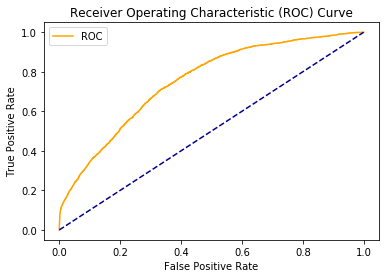

In [427]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
probs = xgb1.predict_proba(test_X)
auc = roc_auc_score(test_y, probs[:,1])
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(test_y, probs[:,1])
plot_roc_curve(fpr, tpr)

In [459]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


In [461]:
test.impression_time = pd.to_datetime(train.impression_time)
test['impression_hour'] = test.impression_time.dt.strftime('%H')
test.impression_hour = test.impression_hour.astype(int)


In [462]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,impression_hour
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-11-15 00:00:00,44754,127,latest,1,0
1,caac14a5bf2ba283db7708bb34855760,2018-11-15 00:01:00,29656,44,latest,0,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-11-15 00:02:00,25234,296,latest,1,0
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-11-15 00:02:00,22988,207,latest,1,0
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-11-15 00:02:00,35431,242,latest,1,0


In [463]:
#calculation click through Rate
#CTR= no of clicks of 1 /total no of impressions
test=pd.merge(test,train[['user_id','CTR_y']],on ='user_id',how='left')
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,impression_hour,CTR_y
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-11-15 00:00:00,44754,127,latest,1,0,NaN
1,caac14a5bf2ba283db7708bb34855760,2018-11-15 00:01:00,29656,44,latest,0,0,3.790315
2,caac14a5bf2ba283db7708bb34855760,2018-11-15 00:01:00,29656,44,latest,0,0,3.940887
3,caac14a5bf2ba283db7708bb34855760,2018-11-15 00:01:00,29656,44,latest,0,0,4.657017
4,caac14a5bf2ba283db7708bb34855760,2018-11-15 00:01:00,29656,44,latest,0,0,4.810103


In [464]:
test["impression_day"]=test.impression_time.dt.strftime("%A")
test.head()
test =pd.merge(test,view_log[['user_id','last_view_date','device_type_max','count']].drop_duplicates(),on = 'user_id',how = 'left' )
test['recency'] = test['impression_time'] - test['last_view_date']

X =test.copy()
X.drop({'last_view_date','impression_id','impression_time'},axis = 1, inplace = True)
X.drop_duplicates(inplace=True)
#X.fillna(0)
# make os_version a int 
X['os_version_'] = X['os_version'].map(lambda x : 1 if x == 'latest' else (2 if x == 'intermediate' else 3))
X.os_version_ = X.os_version_.astype(int)
#remove character os_version
X.drop('os_version',axis = 1, inplace =True)
X.rename(columns = {'os_version_' : 'os_version'},inplace =True)
# one hot encode the columns device type and os version for better analysis via binary values in columns
dummies_device_type  = pd.get_dummies(X['device_type_max'])
dummies_device_type.rename(columns = {1 : 'device_type_1',2 : 'device_type_2', 3 : 'device_type_3' },inplace = True)
dummies_os_version = pd.get_dummies(X['os_version'])
dummies_os_version.rename(columns = {1 : 'os_version_1',2 : 'os_version_2', 3 : 'os_version_3' },inplace = True)
X = X.join(dummies_os_version)
X = X.join(dummies_device_type)
X.drop({'device_type_max','os_version'},inplace=True,axis=1)
X.shape
# make the features and labels dataframes
#y = X[['is_click']]
#X.drop('is_click',inplace=True,axis = 1)
#X.reset_index(inplace=True, drop=True)


X.loc[:,'recency'] =  X.loc[:,'recency'].dt.seconds
X.recency = X.recency.fillna(0)
X.recency = X.recency.astype(int)
#X.drop('os_version_1',axis=1,inplace=True) # recency,ctr,impression_hour,count,os_version_1
X = X.fillna(0)



ValueError: invalid literal for int() with base 10: 'Thursday'

In [465]:
dummies_os_version = pd.get_dummies(X['impression_day'])
dummies_os_version.rename(columns = {'Monday' : 1,'Tuesday' : 2, 'Wednesday' : 3,'Thursday' : 4, 'Friday' : 5, },inplace = True)
X = X.join(dummies_os_version)


,user_id,app_code,is_4G,impression_hour,CTR_y,impression_day,count,recency,os_version_1,os_version_2,os_version_3,device_type_1,device_type_2
0,44754,127,1,0,0,Thursday,1.0,17940,1,0,0,1,0
1,29656,44,0,0,3,Thursday,72.0,31380,1,0,0,1,0
2,29656,44,0,0,3,Thursday,72.0,31380,1,0,0,1,0
3,29656,44,0,0,4,Thursday,72.0,31380,1,0,0,1,0
4,29656,44,0,0,4,Thursday,72.0,31380,1,0,0,1,0


In [466]:
train_X = my_imputer.fit_transform(X)


ValueError: could not convert string to float: 'Thursday'

In [478]:
test_X = pd.DataFrame(test_X)

In [479]:
type(test_X)

pandas.core.frame.DataFrame

In [480]:
test_X['ss'] = yhat

In [451]:
pd.DataFrame(yhat,columns = {'is_click'}).head()['is_click']

0    0
1    0
2    0
3    0
4    0
Name: is_click, dtype: int64